**ASL & Visual Recognition**

Hi, in order to make this kernel, i used some other kernels. If you are curious, go check them : 
https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu
https://www.kaggle.com/kairess/99-9-asl-alphabet-classification-with-slimcnn

And here for the webcam with cv2 :
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html

Warning : Using only 26 class data (A-Z). Removed "Space", "Del" & "Nothing" from the original DataSet


**Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import datetime
import itertools

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout 
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.layers import DepthwiseConv2D, BatchNormalization, LeakyReLU
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image

from PIL import Image

from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(5)

print("import done")


Using TensorFlow backend.


import done


In [2]:
epochs = 50
batch_size = 64
imageSize = 64
dim = 3
target_size = (imageSize, imageSize)
target_dims = (imageSize, imageSize, dim)
target_dims_NN = (1, imageSize, imageSize, dim)
num_classes = 26

data_dir = "datasets/asl-alphabet-train"

print("vars initialize")


vars initialize


**Vars & Data Augmentation**

In [3]:
data_augmentor = ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    validation_split=0.1)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, class_mode='categorical', shuffle=True, batch_size=batch_size, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, class_mode='categorical', shuffle=True, batch_size=batch_size, subset="validation")


Found 77885 images belonging to 26 classes.
Found 8642 images belonging to 26 classes.


**Model & Training**

In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=1, padding="same", input_shape=target_dims))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU())

model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=3, strides=1, padding="same"))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU())

model.add(DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'))     
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=1, strides=1, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU())

model.add(DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'))     
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU()) 
model.add(Conv2D(32, kernel_size=1, strides=1, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU())

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

model.save("model.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_3 (LeakyR

In [5]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3)

callbacks_list = [checkpoint, reduce]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1217/1217 [==============================] - 488s 401ms/step - loss: 1.9839 - acc: 0.3771 - val_loss: 1.5840 - val_acc: 0.4193

Epoch 00001: val_acc improved from -inf to 0.41935, saving model to weights-improvement-01-0.42.hdf5
Epoch 2/50
1217/1217 [==============================] - 341s 281ms/step - loss: 0.8184 - acc: 0.7200 - val_loss: 1.0464 - val_acc: 0.6559

Epoch 00002: val_acc improved from 0.41935 to 0.65587, saving model to weights-improvement-02-0.66.hdf5
Epoch 3/50
1217/1217 [==============================] - 344s 283ms/step - loss: 0.5414 - acc: 0.8147 - val_loss: 0.4661 - val_acc: 0.8455

Epoch 00003: val_acc improved from 0.65587 to 0.84552, saving model to weights-improvement-03-0.85.hdf5
Epoch 4/50
1217/1217 [==============================] - 346s 284ms/step - loss: 0.4003 - acc: 0.8640 - val_loss: 0.3851 - val_acc: 0.8528

Epoch 00004: val_acc improved from 0.84552 to 0.85281, saving model to weights-improvem

**Plots**

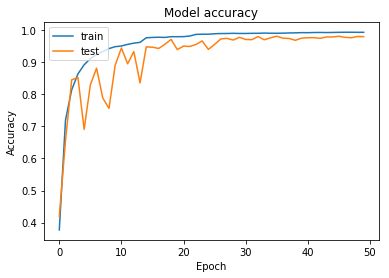

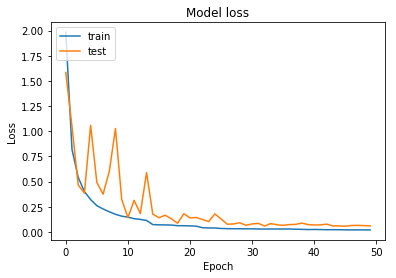

In [6]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

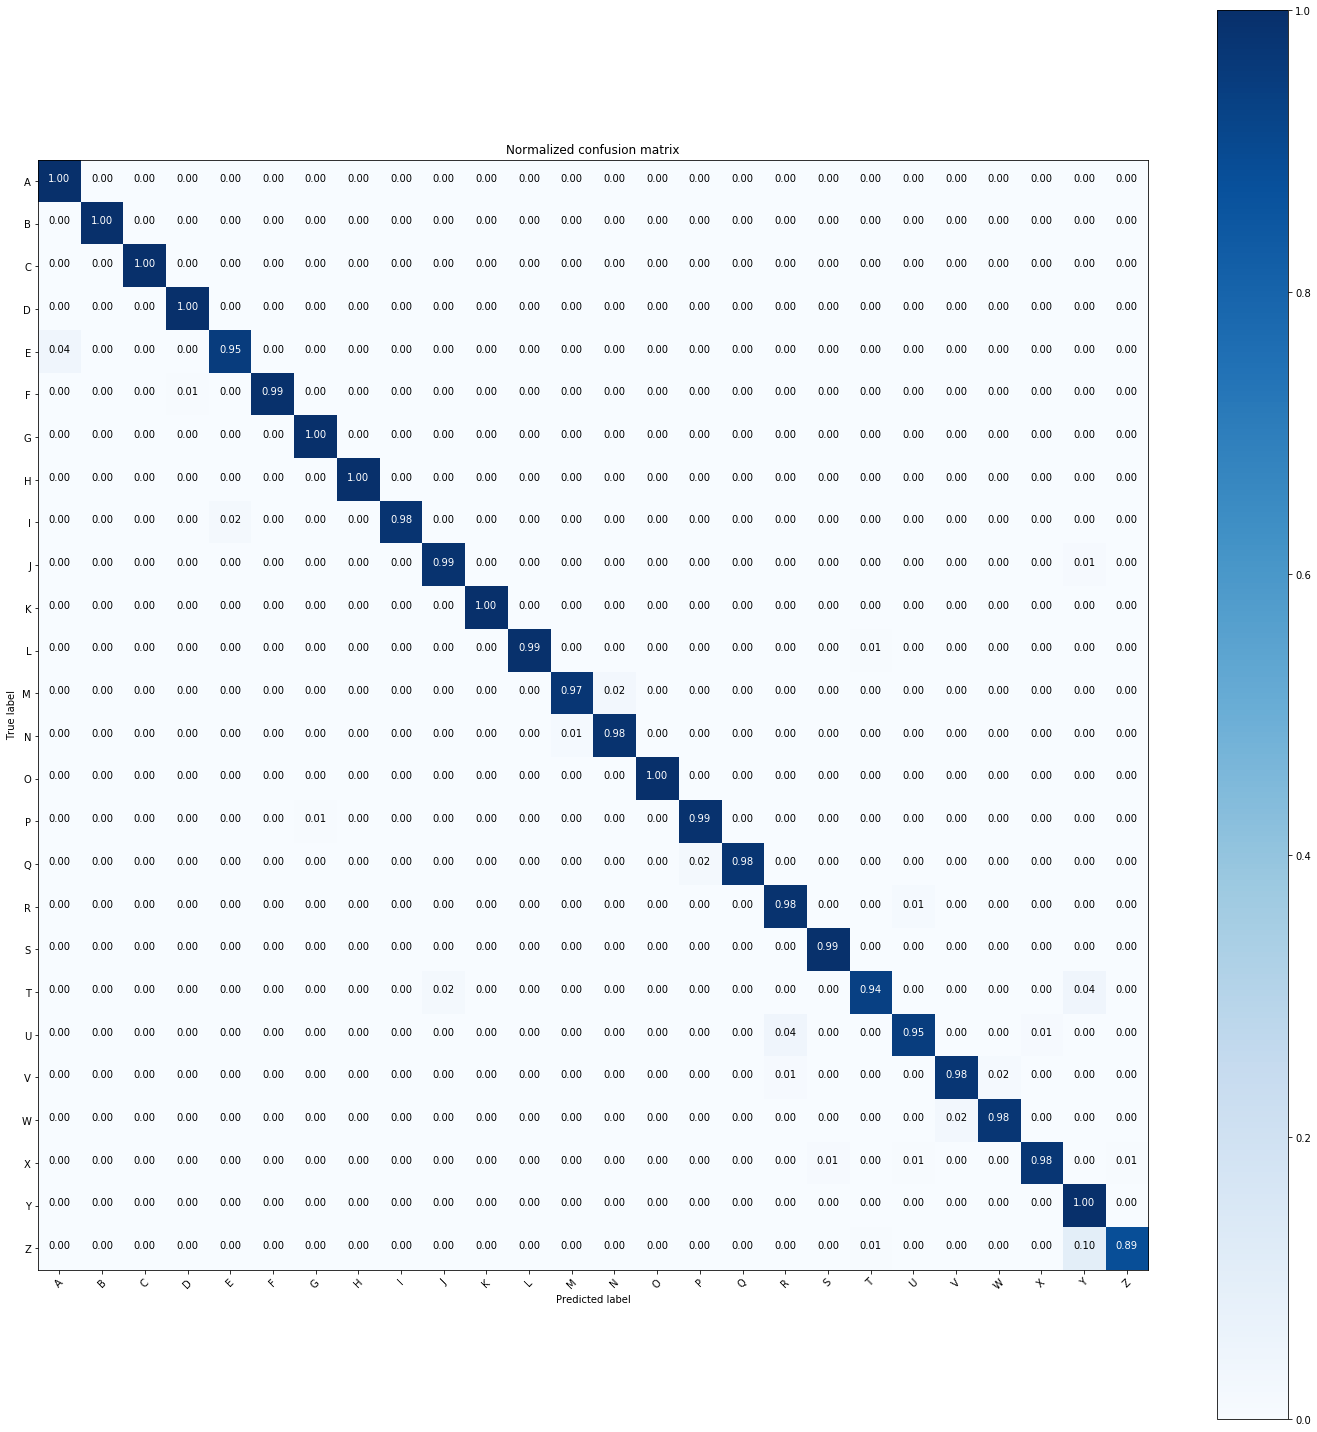

In [7]:
y_test = []
y_pred = []

# get all labels & labels pred
for test in range(len(val_generator)):
    
    x,y = val_generator.next()
    for i in range(0,len(x)):

        real = np.argmax(y[i])  
        y_test.append(real) 

        image = x[i,:,:,:]
        predicted = image.reshape(target_dims_NN)
        predicted = np.array(predicted)
        predicted = model.predict(predicted)
        predicted = np.argmax(predicted)
        y_pred.append(predicted) 

# get class names for nice visualisation
class_names = val_generator.class_indices.keys()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

**Predict from webcam**

Doesn't work with Kaggle, should download and delete the # from this part.

In [8]:
#def predict_from_frame(im):

#    # Resizing image
#    im = cv2.resize(im, (64, 64))
#    im = im[:,:,::-1].astype(np.float32) # Because GBR and not RGB
#    im = image.img_to_array(im)
#    im = np.expand_dims(im, axis=0)
    
#    # Get prediction
#    prediction = model.predict(im)
#    prediction = np.argmax(prediction,axis=1)
#    labels = (train_generator.class_indices)
#    labels = dict((v,k) for k,v in labels.items())
    
#    prediction = labels[prediction[0]]
    
#    return prediction

#def draw_rectangle(frame):
    
#        # Draw rectangle
#        height, width, channels = frame.shape
#        x = int(width/2) - 100
#        w = int(width/2) + 100
#        y = int(height/2) - 100
#        h = int(height/2) + 100
        
#        # Add +-10 in order to not modify the image with something green
#        cv2.rectangle(frame, (x - 10, y - 10), (w + 10, h + 10), (0, 255, 0), 2)
        
#        # Crop the image
#        im = frame[y:h, x:w]
        
#        return (im)

In [9]:
# count = 0 # Can be used if you want to save new images to the DS

#Load the saved model
#video = cv2.VideoCapture(0)

#while True:
#        _, frame = video.read()
        
#        # Dessine un rectangle et cropp l'image
#        im = draw_rectangle(frame)
        
#        # Entre l'image dans le model et prédit
#        predict_from_frame(im)   

         # Ecrit la prediction
#        cv2.putText(frame, prediction, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        
#        # Display l'image
#        cv2.imshow("Final", frame)
                
#        key=cv2.waitKey(1)
#        if key == ord('q'):
#                break
#        elif key == 13: # Can be used if you want to save new images to the DS
#            count = count + 1
#            cv2.imwrite("datasets/26/Z/Z" + str(count) +".jpg", im)
#video.release()
#cv2.destroyAllWindows()


**Bonus** 

Allow you to visualize what is inside train_generator / val_generator

Delete the # from this part in order to make it run

In [10]:
#x,y = train_generator.next()
#x,y = val_generator.next()

#for i in range(0,len(x)):
#    image = x[i]
#    plt.imshow(image)
#    plt.show()
    
#    prediction = np.argmax(y[i])
#    labels = (train_generator.class_indices)
#    labels = dict((v,k) for k,v in labels.items())
    
#    p = image.reshape(target_dims_NN)
#    p = np.array(p)
#    p = model.predict(p)
#    p = np.argmax(p)
#    print(p)
#    print(y[i])
#    print(prediction)
#    print(labels[prediction])

**Bonus** 

If you want to load a model and some weights ...

Delete the # from this part in order to make it run

In [11]:
#print("Loading model to disk")
#model = load_model('model.h5')
#model.load_weights('weights-improvement-36-0.98.hdf5')
#print("Loaded model to disk")